In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os



In [2]:
facenet = cv2.dnn.readNet('models/deploy.prototxt','models/res10_300x300_ssd_iter_140000.caffemodel')
model = load_model('models/mask_detector.model')


#facenet 얼굴이있는 사진과, model 마스크이미지를 불러온다.
#얼굴이 있는 사진은 오픈cv2의 dnn를 활용하여 불러오고, 마스크이미지는 케라스모델을 활용하여 명령한다.

In [58]:
print (img.shape)

(349, 620, 3)


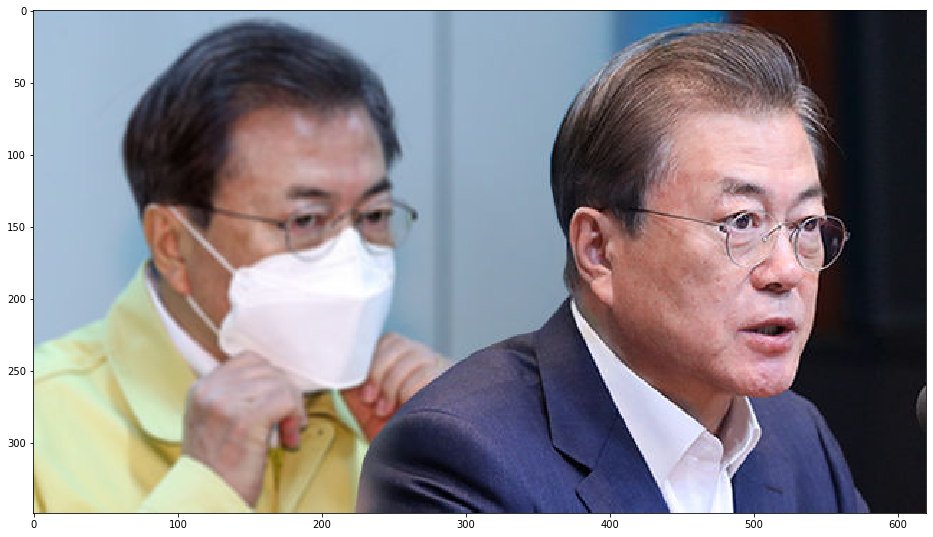

In [54]:
img=cv2.imread('imgs/01.jpg')
h,w = img.shape[:2]


plt.figure(figsize=(16,10))
plt.imshow(img[:, :, ::-1])

#이제 테스트 해볼 이미지를 로드해보자. 오픈 cv2의 아이엠리드 명령으로 이미지를 불러온다.

In [55]:
blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300,300), mean=(104., 177., 123.))
facenet.setInput(blob)
dets = facenet.forward()

#얼굴이 어디있는지 찾아보고, 얼굴을 잘라서 자른얼굴에 마스크가 있는지 없는지 판단한 후에 dets에 저장한다

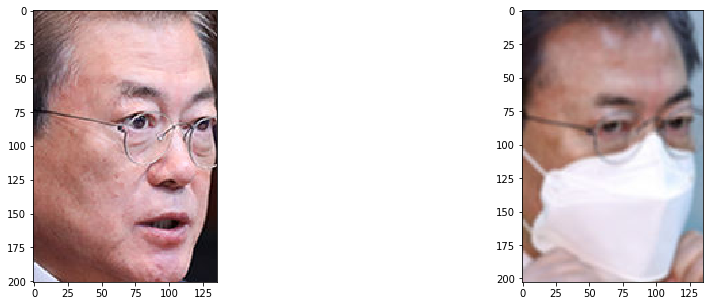

In [56]:
faces = []

for i in range(dets.shape[2]):
    confidence = dets[0,0,i,2]
    if confidence < 0.5:
        continue
        
    x1 = int(dets[0,0,i,3] * w)
    y1 = int(dets[0,0,i,4] * h)
    x2 = int(dets[0,0,i,5] * w)
    y2 = int(dets[0,0,i,6] * h)

    
    face = img[y1:y2, x1:x2]
    faces.append(face)
    
plt.figure(figsize=(16, 5))

for i, face in enumerate(faces):
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:,:,::-1])
    
    
    
#얼굴만 자른다음에, 0.5미만이면 그냥 넘기고. 그 이상인것들만, 원본이미지에서 얼굴만 잘라내서 얼굴이 잘 나왔나 imshow로 결과 보여줌.

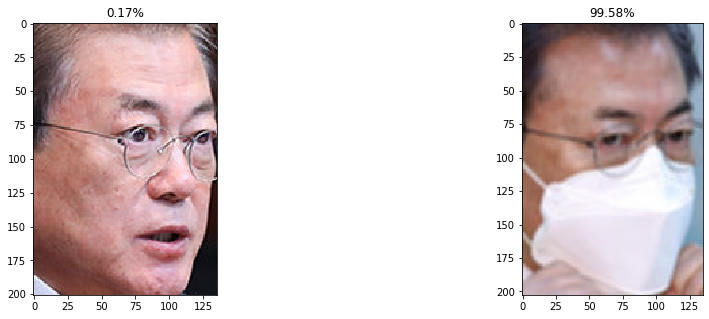

In [57]:
plt.figure(figsize=(16,5))

for i, face in enumerate(faces):
    face_input = cv2.resize(face, dsize=(224, 224))
    face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
    face_input = preprocess_input(face_input)
    face_input = np.expand_dims(face_input, axis=0)
    
    mask, nomask = model.predict(face_input).squeeze()
    
    plt.subplot(1, len(faces), i+1)
    plt.imshow(face[:,:,::-1])
    plt.title('%.2f%%' % (mask * 100))
    

#사진에 마스크가 있는지 없는지 예측하기. / 차원을 추가하여 로드한 이미지의 .. 마스크를 쓴이미지의 확률 ! 계산해보기

# facenet = cv2.dnn.readNet('models/deploy.prototxt', 'models/res10_300x300_ssd_iter_140000.caffemodel')
model = load_model('models/mask_detector.model')

cap = cv2.VideoCapture('imgs/01.mp4')
ret, img = cap.read()

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (img.shape[1], img.shape[0]))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    h, w = img.shape[:2]

    blob = cv2.dnn.blobFromImage(img, scalefactor=1., size=(300, 300), mean=(104., 177., 123.))
    facenet.setInput(blob)
    dets = facenet.forward()

    result_img = img.copy()

    for i in range(dets.shape[2]):
        confidence = dets[0, 0, i, 2]
        if confidence < 0.5:
            continue

        x1 = int(dets[0, 0, i, 3] * w)
        y1 = int(dets[0, 0, i, 4] * h)
        x2 = int(dets[0, 0, i, 5] * w)
        y2 = int(dets[0, 0, i, 6] * h)
        
        face = img[y1:y2, x1:x2]

        face_input = cv2.resize(face, dsize=(224, 224))
        face_input = cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB)
        face_input = preprocess_input(face_input)
        face_input = np.expand_dims(face_input, axis=0)
        
        mask, nomask = model.predict(face_input).squeeze()

        if mask > nomask:
            color = (0, 255, 0)
            label = 'Mask %d%%' % (mask * 100)
        else:
            color = (0, 0, 255)
            label = 'No Mask %d%%' % (nomask * 100)

        cv2.rectangle(result_img, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=color, lineType=cv2.LINE_AA)
        cv2.putText(result_img, text=label, org=(x1, y1 - 10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.8, color=color, thickness=2, lineType=cv2.LINE_AA)

    out.write(result_img)
    cv2.imshow('result', result_img)
    if cv2.waitKey(1) == ord('q'):
        break

out.release()
cap.release()
